In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from utils import *
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import torch

In [26]:
train_dir = 'data_loader/train'
test_dir= 'data_loader/test'

In [30]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
#         transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])
    ])

In [45]:
train_data = datasets.ImageFolder(train_dir,transform=train_transform)
test_data = datasets.ImageFolder(test_dir,transform=test_transform)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes
print("Classes: ",class_names)
print("Training images #: ", len(train_data))
print("Test images #: ", len(test_data))

Classes:  ['COVID-19', 'bacteria', 'normal', 'viral']
Training images #:  5310
Test images #:  639


Label: [2 3 0 1 2 1 1 1 3 0]
Class: normal viral COVID-19 bacteria normal bacteria bacteria bacteria viral COVID-19


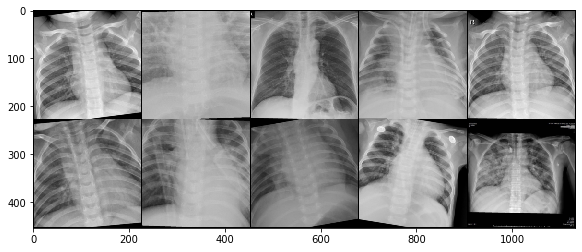

In [47]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
# inv_normalize = transforms.Normalize(
#     mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
#     std=[1/0.229, 1/0.224, 1/0.225]
# )
# im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

# Transfer Learning

In [48]:
resnet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/nicolaecadin/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [51]:
for param in resnet.parameters():
    param.requires_grad=False

In [56]:
print(resnet.fc)
resnet.fc = torch.nn.Linear(2048,4)

Linear(in_features=2048, out_features=1000, bias=True)


In [57]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.fc.parameters(),lr=0.001)

In [59]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = resnet(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = resnet(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.23051186  accuracy:  72.300%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.39978546  accuracy:  71.825%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.55680543  accuracy:  72.000%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.60797280  accuracy:  71.925%
epoch:  2  batch:  200 [  2000/8000]  loss: 1.39714813  accuracy:  72.350%
epoch:  2  batch:  400 [  4000/8000]  loss: 0.59741151  accuracy:  71.950%

Duration: 3775 seconds
